# Lab 1 : First order methods on regression models

#### Authors: A. Gramfort, R. Gower, P. Ablin

## Aim

The aim of this material is to code 
- proximal gradient descent (ISTA)
- accelerated gradient descent (FISTA) 

for 
- linear regression
- logistic regression 

models.

The proximal operators we will use are the 
- ridge penalization
- L1 penalization

## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work **before the 7th of october at 23:59**, using the **moodle platform**.
- This means that **each student in the pair sends the same file**
- On the moodle, in the "Optimization for Data Science" course, you have a "devoir" section called **Rendu TP du 2 octobre 2017**. This is where you submit your jupyter notebook file. 
- The **name of the file must be** constructed as in the next cell

# Gentle reminder: no evaluation if you don't respect this EXACTLY

### How to construct the name of your file

In [2]:
# Change here using YOUR first and last names
fn1 = "aymen"
ln1 = "dabghi"
fn2 = "salma"
ln2 = "jeridi"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["lab1", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

lab1_dabghi_aymen_and_jeridi_salma.ipynb


In [3]:
## to embed figures in the notebook
%matplotlib inline

## Part 0 : Introduction

We'll start by generating sparse vectors and simulating data

### Getting sparse coefficients

In [4]:
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(precision=2)  # to have simpler print outputs with numpy

Text(0.5,1,u'Parameters / Coefficients')

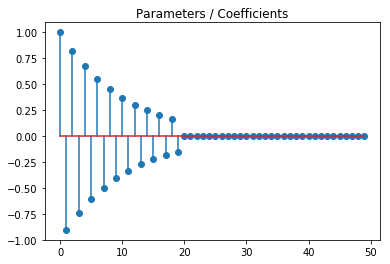

In [5]:
n_features = 50
n_samples = 1000
idx = np.arange(n_features)
coefs = ((-1) ** idx) * np.exp(-idx / 10.)
coefs[20:] = 0.
plt.stem(coefs)
plt.title("Parameters / Coefficients")

### Functions for the simulation of the models

In [6]:
from numpy.random import multivariate_normal
from scipy.linalg.special_matrices import toeplitz
from numpy.random import randn


def simu_linreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a linear regression model
    
    Parameters
    ----------
    coefs : `numpy.array`, shape (n_features,)
        Coefficients of the model
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation of the features

    Returns
    -------
    A : `numpy.ndarray`, shape (n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian 
        vector with covariance given by the Toeplitz matrix
    
    b : `numpy.array`, shape (n_samples,)
        Simulated labels
    """
    # Construction of a covariance matrix
    cov = toeplitz(corr ** np.arange(0, n_features))
    # Simulation of features
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    # Simulation of the labels
    b = A.dot(coefs) + randn(n_samples)
    return A, b

def sigmoid(t):
    """Sigmoid function"""
    return 1. / (1. + np.exp(-t))

def simu_logreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a logistic regression model
    
    Parameters
    ----------
    coefs : `numpy.array`, shape (n_features,)
        Coefficients of the model
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation of the features

    Returns
    -------
    A : `numpy.ndarray`, shape (n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian 
        vector with covariance given by the Toeplitz matrix
    
    b : `numpy.array`, shape (n_samples,)
        Simulated labels
    """
    cov = toeplitz(corr ** np.arange(0, n_features))
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    p = sigmoid(A.dot(coefs))
    b = np.random.binomial(1, p, size=n_samples)
    b = 2 * b - 1
    return A, b

## Part 1 : Proximal operators

We remind that the proximal operator of a fonction $g$ is given by:

$$
\text{prox}_g(x) = \arg\min_z \left\{ \frac{1}{2} \Vert x - z\Vert_2^2 + g(z) \right\}.
$$


We have in mind to use the following cases

- Ridge penalization, where $g(z) = \frac{s}{2} \|z\|_2^2$
- Lasso penalization, where $g(z) = s \|z|\|_1$

where $s \geq 0$ is a regularization parameter.

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Code a function that computes $g(x)$ in both cases and $\text{prox}_g(x)$ for ridge and  lasso penalization (use the slides of the first course to get the formulas), using the prototypes given below</li>
      <li>Visualize the functions applied element wise by the proximity operators of the Ridge and Lasso 
    </li>
    </ul>
</div>

In [7]:
def prox_lasso(x, s):
    """Proximal operator for the Lasso at x"""  
    return np.sign(x) * np.maximum((np.abs(x) - s) , 0) 
    
def lasso(x, s):
    """Value of the Lasso penalization at x"""
    return s * np.linalg.norm(x , ord=1) 

def prox_ridge(x, s):
    """Proximal operator for the ridge at x"""
    return np.true_divide(x,(1+s)) 
    
def ridge(x, s):
    """Value of the ridge penalization at x"""
    return 0.5 * s * np.linalg.norm(x , ord=2) ** 2

## Visualization

We are now going to visualize the effect of the proximity operators on coefficients.

(-2, 2)

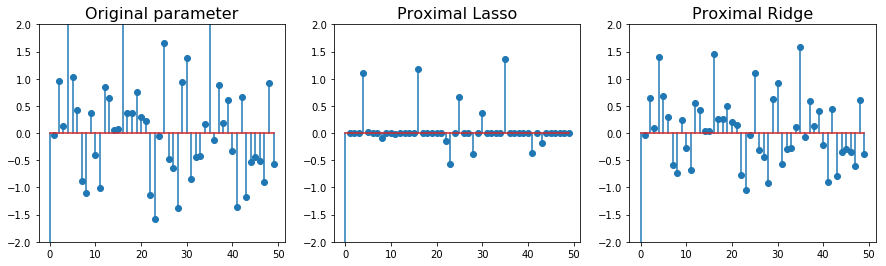

In [8]:
x = np.random.randn(50)
l_l1 = 1.
l_l2 = 0.5

plt.figure(figsize=(15.0, 4.0))
plt.subplot(1, 3, 1)
plt.stem(x)
plt.title("Original parameter", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 2)
plt.stem(prox_lasso(x, s=l_l1))
plt.title("Proximal Lasso", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 3)
plt.stem(prox_ridge(x, s=l_l2))
plt.title("Proximal Ridge", fontsize=16)
plt.ylim([-2, 2])

<div class="alert alert-success">
    <b>Question</b>:
     <ul>
      <li>Comment what you observe (1 or 2 sentences).</li>
    </ul>
</div>


<div class="alert alert-info">
    <b>Answer</b>:
     <p>$\bullet$ When using Lasso proximal operator, we just shrinked the small values of the coefficients (that are between $s$ and $-s$ : $-s < x < s$) to zeros and the other values are just reduced by $-s$ in absolute value. Therefore, we induced sparsity into the problem structure.</p>
     
   <p>$\bullet$ When using Ridge proximal operator, all we did was dividing our vector's coefficients by $1+s$ which means we reduced their values by the factor $\frac{1}{1+s}$ without setting any to zero.</p>
     
</div>


## Part 2: Gradients

The problems we want to minimize take the form:
$$
\arg\min_x f(x) + g(x)
$$
where $f$ is $L$-smooth and $g$ is prox-capable.

Consider the following cases:

**Linear regression**, where 
$$
f(x) = \frac{1}{2n} \sum_{i=1}^n (b_i - a_i^\top x)^2 = \frac{1}{2 n} \| b - A x \|_2^2,
$$
where $n$ is the sample size, $b = [b_1 \cdots b_n]$ is the vector of labels and $A$ is the matrix of features.

**Logistic regression**, where
$$
f(x) = \frac{1}{n} \sum_{i=1}^n \log(1 + \exp(-b_i a_i^\top x)),
$$
where $n$ is the sample size, and where labels $b_i \in \{ -1, 1 \}$ for all $i$.

We need to be able to compute $f$ and its gradient

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Compute on paper the gradient $\nabla f$ of $f$ for both cases (linear and logistic regression)</li>
      <li>Code a function that computes $f$ and its gradient $\nabla f$ in both cases, using the prototypes below.</li>
      <li>Check that these functions are correct by numerically checking the gradient, using the function ``<a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.check_grad.html">check_grad</a>`` from ``scipy.optimize``. Remark: use the functions `simu_linreg` and `simu_logreg` to simulate data according to the right model</li>
    </ul>
</div>

<div class="alert alert-info">
    <b>Answer:</b>  
    $\bullet \text{Linear regression gradient :}\\
    \hspace{1cm} \nabla f = \frac{1}{n} A^\top (Ax-b)\\
    \bullet \text{Logistic regression gradient :} \\
    \hspace{1cm} \nabla f = \frac{1}{n} \sum_{i=1}^n \frac{-b_i a_i^\top x}{1+\exp(b_i a_i^\top x)}$
     
</div>

In [9]:
from numpy.linalg import norm

In [10]:
def loss_linreg(x):
    """Least-squares loss"""
    return 1/(2*float(n)) * np.linalg.norm(b - np.dot(A,x) , ord=2) ** 2


def grad_linreg(x):
    """Leas-squares gradient"""
    # TODO
    return 1/float(n) * np.dot(A.T , np.dot(A,x) - b)

def loss_logreg(x):
    """Logistic loss"""
    ans = 0
    for i in range(n):
        ans += np.log(1 + np.exp(-b_log[i]*np.dot(A_log[i],x)))
    return ans / float(n)

def grad_logreg(x):
    """Logistic gradient"""
    return (1/float(n))*sum((-b_log[i]*np.transpose(A_log[i, :])*np.exp(-b_log[i]*np.dot(np.transpose(A_log[i, :]), x)))/(1 + np.exp(-b_log[i]*np.dot(np.transpose(A_log[i, :]), x))) for i in range(n))


In [11]:
from scipy.optimize import check_grad
x= np.ones(50)
A,b=simu_linreg(coefs)
A_log,b_log=simu_logreg(coefs)
n=n_samples
print 'Check the linreg gradient : ' ,check_grad(loss_linreg, grad_linreg, x)
print 'Check the logreg gradient : ' ,check_grad(loss_logreg, grad_logreg, x)

Check the linreg gradient :  6.80465482834e-06
Check the logreg gradient :  2.79951183179e-06


## Part 3: Solvers

We know have a function to compute $f$, $\nabla f$ and $g$ and $\text{prox}_g$. 

We want now to code the Ista and Fista solvers to minimize

$$
\arg\min_x f(x) + g(x)
$$

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Implement functions that compute the Lipschitz constants for linear and 
  logistic regression losses. Note that the operator norm of a matrix can 
  be computed using the function <a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.norm.html">numpy.linalg.norm</a> (read the documentation
  of the function)</li>
      <li>Finish the functions `ista` and `fista` below that implements the 
  ISTA (Proximal Gradient Descent) and FISTA (Accelerated Proximal 
  Gradient Descent) algorithms</li>
    </ul>
</div>

In [12]:
import scipy


def lip_linreg(A):
    """Lipschitz constant for linear squares loss"""    
    return 1/float(n) * norm(A , ord=2) ** 2
    
def lip_logreg(A):
    """Lipschitz constant for logistic loss"""    
    return  1/(4*float(n)) * norm(A , ord=2) ** 2

In [13]:
def ista(x0, f, grad_f, g, prox_g, step, s=0., n_iter=50,
         x_true=coefs, verbose=True):
    """Proximal gradient descent algorithm
    """
    x = x0.copy()
    x_new = x0.copy()
    n_samples, n_features = A.shape

    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = norm(x - x_true) / norm(x_true)
    errors.append(err)
    # Current objective
    obj = f(x) + g(x, s)
    objectives.append(obj)
    if verbose:
        print("Lauching ISTA solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    for k in range(n_iter + 1):

        x = prox_g(x - (1/step) * grad_f(x) , s/step)
        
        obj = f(x) + g(x, s)
        err = norm(x - x_true) / norm(x_true)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
    return x, objectives, errors

In [14]:
def fista(x0, f, grad_f, g, prox_g, step, s=0., n_iter=50,
         x_true=coefs, verbose=True):
    """Accelerated Proximal gradient descent algorithm
    """
    x = x0.copy()
    x_new = x0.copy()
    # An extra variable is required for FISTA
    z = x0.copy()
    n_samples, n_features = A.shape
    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = norm(x - x_true) / norm(x_true)
    errors.append(err)
    # Current objective
    obj = f(x) + g(x, s)
    objectives.append(obj)
    t = 1.
    t_new = 1.    
    if verbose:
        print("Lauching FISTA solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    for k in range(n_iter + 1):

        x_new = prox_g(z - ((1/step) * grad_f(z)) , s/step)
        t_new = (1+np.sqrt(1+4*t**2))/2
        z_new = x_new + ((t-1)/(t_new))*(x_new - x)
        x = x_new
        z = z_new
        t = t_new

        obj = f(x) + g(x, s)
        err = norm(x - x_true) / norm(x_true)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
    return x, np.array(objectives), np.array(errors)

## Algorithms comparison and numerical experiments

In [15]:
# Some definitions before launching the algorithms
x0 = np.zeros(n_features)
s = 1e-2

A,b=simu_linreg(coefs)
A_log,b_log=simu_logreg(coefs)
n=len(b)

In [16]:
# We run the ISTA algorithm the first time with the verbose value set to False and with a large number of 
# iterations so we can have the x_true that will be used as reference for the rest of the problem

x_to_use,obj,err=ista(x0,loss_linreg,grad_linreg,ridge,prox_ridge,step=lip_linreg(A),s=s,n_iter=1000 , 
                      verbose=False)
print 'x_true = ' , x_to_use

x_true =  [ 1.01 -0.91  0.84 -0.71  0.7  -0.54  0.44 -0.48  0.47 -0.41  0.37 -0.25
  0.24 -0.23  0.21 -0.21  0.19 -0.15  0.16 -0.17 -0.01  0.05 -0.03  0.07
 -0.06  0.01  0.06  0.02 -0.04 -0.02  0.01 -0.04  0.    0.11 -0.02 -0.02
  0.01 -0.    0.05 -0.05  0.02 -0.02 -0.03  0.02 -0.03  0.05 -0.07  0.06
 -0.02  0.01]


In [17]:
x_ista,obj_ista,err_ista=ista(x0,loss_linreg,grad_linreg,ridge,prox_ridge,step=lip_linreg(A),s=s,n_iter=300 , 
                    x_true=x_to_use)

Lauching ISTA solver...
   it    |   obj    |   err   
       0 | 1.22e+00 | 8.78e-01
      10 | 5.45e-01 | 2.79e-01
      20 | 4.85e-01 | 9.54e-02
      30 | 4.79e-01 | 3.41e-02
      40 | 4.78e-01 | 1.25e-02
      50 | 4.78e-01 | 4.74e-03
      60 | 4.78e-01 | 1.82e-03
      70 | 4.78e-01 | 7.15e-04
      80 | 4.78e-01 | 2.84e-04
      90 | 4.78e-01 | 1.15e-04
     100 | 4.78e-01 | 4.66e-05
     110 | 4.78e-01 | 1.91e-05
     120 | 4.78e-01 | 7.88e-06
     130 | 4.78e-01 | 3.26e-06
     140 | 4.78e-01 | 1.36e-06
     150 | 4.78e-01 | 5.66e-07
     160 | 4.78e-01 | 2.37e-07
     170 | 4.78e-01 | 9.90e-08
     180 | 4.78e-01 | 4.15e-08
     190 | 4.78e-01 | 1.74e-08
     200 | 4.78e-01 | 7.29e-09
     210 | 4.78e-01 | 3.06e-09
     220 | 4.78e-01 | 1.29e-09
     230 | 4.78e-01 | 5.40e-10
     240 | 4.78e-01 | 2.27e-10
     250 | 4.78e-01 | 9.53e-11
     260 | 4.78e-01 | 4.00e-11
     270 | 4.78e-01 | 1.68e-11
     280 | 4.78e-01 | 7.07e-12
     290 | 4.78e-01 | 2.97e-12
     300 | 4.78

In [18]:
x_fista,obj_fista,err_fista=fista(x0,loss_linreg,grad_linreg,ridge,prox_ridge,step=lip_linreg(A),s=s,n_iter=300 , 
                      x_true=x_to_use)

Lauching FISTA solver...
   it    |   obj    |   err   
       0 | 1.22e+00 | 8.78e-01
      10 | 4.79e-01 | 3.14e-02
      20 | 4.78e-01 | 1.13e-02
      30 | 4.78e-01 | 4.53e-03
      40 | 4.78e-01 | 2.03e-03
      50 | 4.78e-01 | 9.97e-04
      60 | 4.78e-01 | 5.09e-04
      70 | 4.78e-01 | 2.61e-04
      80 | 4.78e-01 | 1.32e-04
      90 | 4.78e-01 | 6.61e-05
     100 | 4.78e-01 | 3.24e-05
     110 | 4.78e-01 | 1.54e-05
     120 | 4.78e-01 | 7.22e-06
     130 | 4.78e-01 | 3.47e-06
     140 | 4.78e-01 | 1.92e-06
     150 | 4.78e-01 | 1.28e-06
     160 | 4.78e-01 | 9.17e-07
     170 | 4.78e-01 | 6.48e-07
     180 | 4.78e-01 | 4.41e-07
     190 | 4.78e-01 | 2.88e-07
     200 | 4.78e-01 | 1.81e-07
     210 | 4.78e-01 | 1.09e-07
     220 | 4.78e-01 | 6.30e-08
     230 | 4.78e-01 | 3.47e-08
     240 | 4.78e-01 | 1.81e-08
     250 | 4.78e-01 | 8.65e-09
     260 | 4.78e-01 | 3.64e-09
     270 | 4.78e-01 | 1.21e-09
     280 | 4.78e-01 | 4.76e-10
     290 | 4.78e-01 | 6.04e-10
     300 | 4.7

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Compute a precise minimum and a precise minimizer of the linear regression with ridge 
  penalization problem using the parameters give above. This can be done by using fista with 
  1000 iterations.</li>
    <li>Compare the convergences of ISTA and FISTA, in terms of distance to the minimum and 
  distance to the minimizer. Do your plots using a logarithmic scale of the y-axis.</li>
    </ul>
</div>

<div class="alert alert-info">
    <b>Answer</b>:
     <p>Using the Ridge penalization on the linear regression, we obtained :</p>
     $\hspace{1cm}\bullet$ The minimum : $0.478$  
     $\hspace{1cm}\bullet$ The minimizer : it is the last $x$ given by the FISTA algorithm = $x_{fista}$
     
</div>

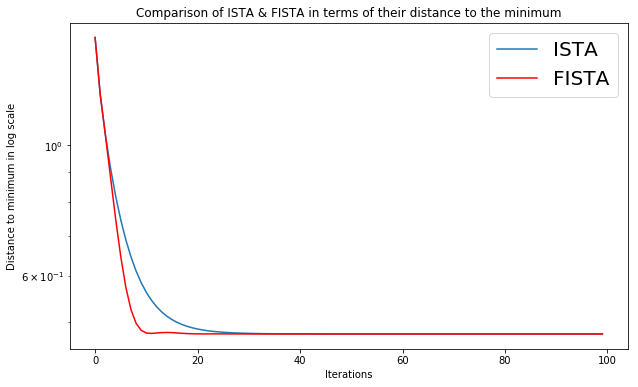

In [19]:
# Distance  to the minimum
plt.figure(figsize=(10,6))
plt.plot(obj_ista[:100] , label = "ISTA")
plt.plot(obj_fista[:100] , 'r' , label = "FISTA")
plt.yscale('log')
plt.xlabel('Iterations')
plt.ylabel('Distance to minimum in log scale')
plt.title('Comparison of ISTA & FISTA in terms of their distance to the minimum')
plt.legend(prop={'size':20})
plt.show()

<div class="alert alert-info">
    <b>Answer</b>:
     <p>We can clearly notice that the FISTA algorithm converges faster than the ISTA algorithm.
     In fact, the minimizer is reached within 18 iterations with ISTA while it is reached within 32 iterations. </p>
     
</div>

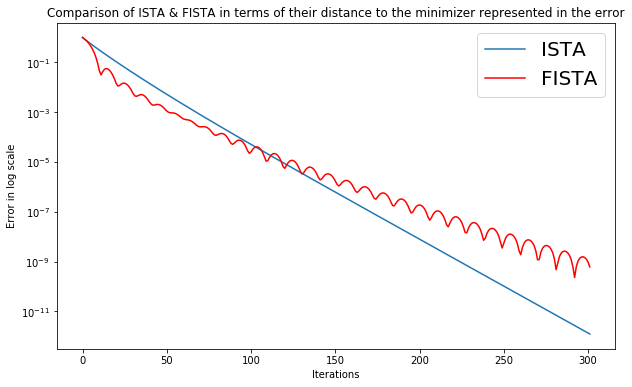

In [20]:
# Distance to the minimizer

# Since the minimizer is a vector, we chose to represent the error instead
plt.figure(figsize=(10,6))
plt.plot(err_ista , label = "ISTA")
plt.plot(err_fista , 'r' , label = "FISTA")
plt.yscale('log')
plt.xlabel('Iterations')
plt.ylabel('Error in log scale')
plt.title('Comparison of ISTA & FISTA in terms of their distance to the minimizer represented in the error')
plt.legend(prop={'size':20})
plt.show()

<div class="alert alert-info">
    <b>Answer</b>:
    <p>We can notice that for the first 100 iterations,  the error related to the FISTA algorithm is smaller than the error of the ISTA algorithm. After that, the curves meet each other and the error of the ISTA become smaller than the error of the FISTA.</p>
    <p></p>We can also notice that the curve of the ISTA decreases linearly due to the fact that ISTA is a descent method while FISTA is not.</p>
     
</div>

<div class="alert alert-success">
    <b>EXERCISE</b>:
     <ul>
      <li>Compare the solution you obtain with ista and fista with the true parameter `coefs` of
  the model. This can be done with `plt.stem` plots.</li>
    <li>In linear regression and logistic regression, study the influence of the correlation 
  of the features on the performance of the optimization algorithms. Explain.</li>
    <li>In linear regression and logistic regression, study the influence of the level of ridge 
  penalization on the performance of the optimization algorithms. Explain.</li>
    <li>In linear regression and logistic regression, compare the performance of the optimization
  algorithms for ridge and lasso penalizations. Explain</li>
    </ul>
</div>

### Comparison with the true parameter coefs :

In [21]:
x_coefs_ista,obj,err=ista(x0,loss_linreg,grad_linreg,ridge,prox_ridge,step=lip_linreg(A),s=s,n_iter=1000 , 
                      verbose=False)
x_coefs_fista,obj,err=ista(x0,loss_linreg,grad_linreg,ridge,prox_ridge,step=lip_linreg(A),s=s,n_iter=1000 , 
                      verbose=False)

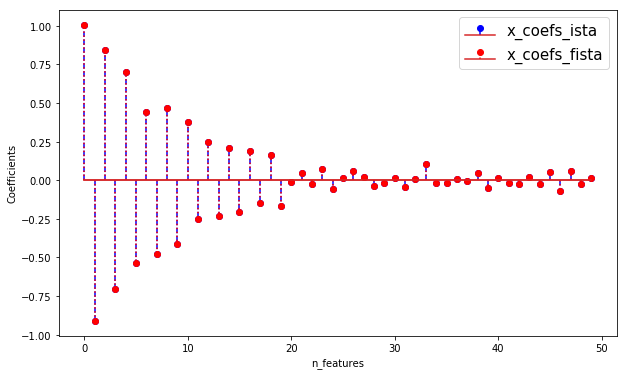

In [22]:
plt.figure(figsize=(10,6))
plt.stem(x_coefs_ista,linefmt='b--',  markerfmt='bo',label='x_coefs_ista')
plt.stem(x_coefs_fista ,linefmt='r:', markerfmt='ro',label='x_coefs_fista')

plt.legend(prop={'size':15})
plt.xlabel('n_features')
plt.ylabel('Coefficients')
plt.show()

<div class="alert alert-info">
    <b>Answer</b>:
    <p> The minimizers obtained with ISTA and FISTA are so close,  both algorithms converge to the same minimizer even with different speed of convergence.
    </p>
     
</div>

## Correlation influence
Here we are going to simulate three datasets with 3 different level of correlation and plot the error rate with ISTA and FISTA algorithms for linear regression and logistic regression ( always with ridge regularization).

### Correlation influence : ISTA and FISTA for linear regression :

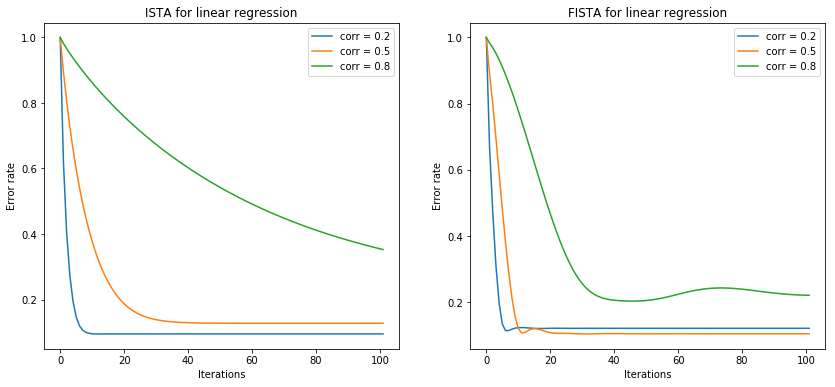

In [23]:
corr = [0.2 , 0.5 , 0.8]
corr_legend = ['corr = 0.2' , 'corr = 0.5' , 'corr = 0.8']

plt.figure(figsize=(14,6))

plt.subplot(1,2,1)

for i in range(3):
    A,b=simu_linreg(coefs,corr=corr[i])
    x_ista,obj,err_ista=ista(x0,loss_linreg,grad_linreg,ridge,prox_ridge,step=lip_linreg(A),s=s,n_iter=100 , 
                      verbose=False)
    plt.xlabel("Iterations")
    plt.ylabel("Error rate")
    plt.plot(err_ista,label=corr_legend[i])
    plt.legend()
    plt.title("ISTA for linear regression")

    
plt.subplot(1,2,2)  

for i in range(3):
    A,b=simu_linreg(coefs,corr=corr[i])
    x_fista,obj,err_fista=fista(x0,loss_linreg,grad_linreg,ridge,prox_ridge,step=lip_linreg(A),s=s,n_iter=100 , 
                      verbose=False)
    plt.xlabel("Iterations")
    plt.ylabel("Error rate")
    plt.plot(err_fista,label=corr_legend[i])
    plt.legend()
    
    plt.title("FISTA for linear regression")

    
plt.show()

### Correlation influence : ISTA and FISTA for logistic regression :

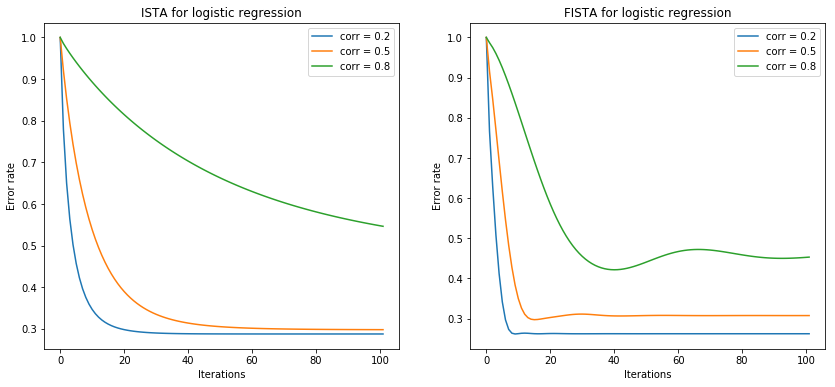

In [24]:
corr = [0.2 , 0.5 , 0.8]
corr_legend = ['corr = 0.2' , 'corr = 0.5' , 'corr = 0.8']
s = 0.01

plt.figure(figsize=(14,6))

plt.subplot(1,2,1)

for i in range(3):
    A_log,b_log=simu_logreg(coefs,corr=corr[i])
    x_ista,obj,err_ista=ista(x0,loss_logreg,grad_logreg,ridge,prox_ridge,step=lip_logreg(A_log),s=s,n_iter=100 , 
                      verbose=False)
    plt.xlabel("Iterations")
    plt.ylabel("Error rate")
    plt.plot(err_ista,label=corr_legend[i])
    plt.legend()
    plt.title("ISTA for logistic regression")

    
plt.subplot(1,2,2)  

for i in range(3):
    A_log,b_log=simu_logreg(coefs,corr=corr[i])
    x_fista,obj,err_fista=fista(x0,loss_logreg,grad_logreg,ridge,prox_ridge,step=lip_logreg(A_log),s=s,n_iter=100 , 
                      verbose=False)
    plt.xlabel("Iterations")
    plt.ylabel("Error rate")
    plt.plot(err_fista,label=corr_legend[i])
    plt.legend()
    plt.title("FISTA for logistic regression")

    
plt.show()

<div class="alert alert-info">
    <b>Answer</b>:
    <p>
    $\bullet$ We can notice that both ISTA and FISTA perform better with linear regression than with logistic regression. They both converge faster with a small error rate with lonear regression comparing to their performances with logistic regression.</p>
    <p>
    $\bullet$ In every case above, the smaller the correlation, the better the performance. In fact, we chose 3 different values of the correlation and 0.2 seems to be the best among the three. We can conclude that both methods (ISTA $\&$ FISTA) suffer from correlated features, which is consistent with the fact that their convergence rate is proportional to the Lipschitz constant of the gradient of $f$, which grows with the amount of correlation.
    </p>
    <p>
    $\bullet$ Another observation is that both methods are close when the correlation value is low but the FISTA method outperforms ISTA when the correlation value gets higher. 
    </p>
     
</div>

## Level of Ridge penalization
Here we are going to implement the algorithms with different strengths of regularization and plot the error rate with ISTA and FISTA algorithms for linear regression and logistis regression ( always with ridge regularization).

### Influence of level of Ridge penalization : ISTA and FISTA for linear regression

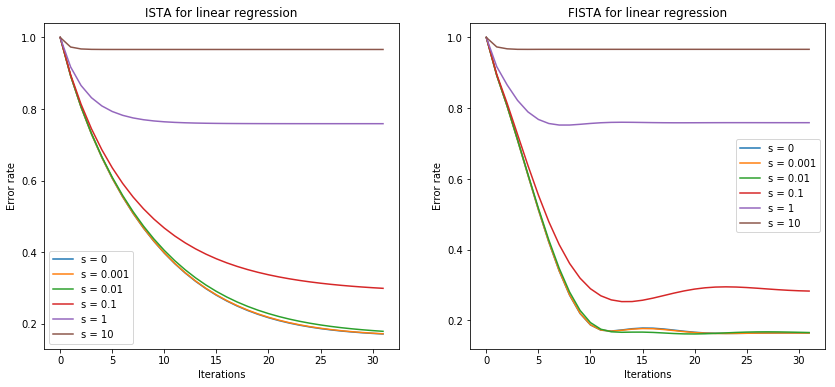

In [25]:
A,b=simu_linreg(coefs)
s = [0 , 0.001 , 0.01 , 0.1 , 1 , 10]
s_legend = ['s = 0','s = 0.001','s = 0.01','s = 0.1','s = 1','s = 10']
plt.figure(figsize=(14,6))

plt.subplot(1,2,1)

for i in range(6):
    
    x_ista,obj,err_ista=ista(x0,loss_linreg,grad_linreg,ridge,prox_ridge,step=lip_linreg(A),s=s[i],n_iter=30 , 
                      verbose=False)
    plt.plot(err_ista,label=s_legend[i])
    plt.legend()
    plt.xlabel("Iterations")
    plt.ylabel("Error rate")
    plt.title("ISTA for linear regression")

    
plt.subplot(1,2,2)  

for i in range(6):
    x_fista,obj,err_fista=fista(x0,loss_linreg,grad_linreg,ridge,prox_ridge,step=lip_linreg(A),s=s[i],n_iter=30 , 
                      verbose=False)
    plt.plot(err_fista,label=s_legend[i])
    plt.legend()
    plt.xlabel("Iterations")
    plt.ylabel("Error rate")
    plt.title("FISTA for linear regression")

    
plt.show()

### Influence of level of Ridge penalization : ISTA and FISTA for logistic regression

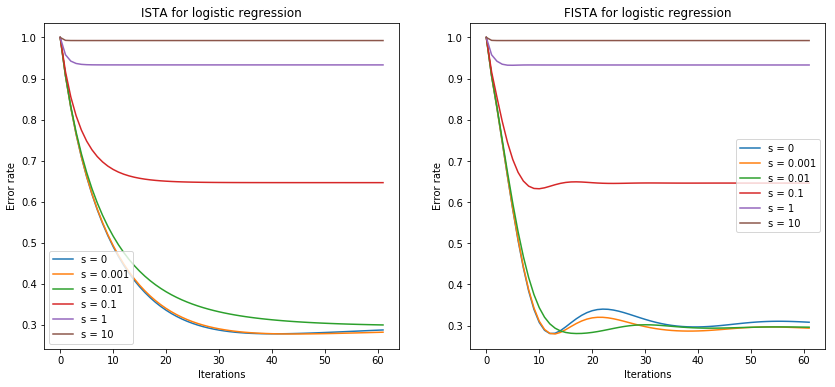

In [26]:
A_log,b_log=simu_logreg(coefs)
s = [0 , 0.001 , 0.01 , 0.1 , 1 , 10]
s_legend = ['s = 0','s = 0.001','s = 0.01','s = 0.1','s = 1','s = 10']
plt.figure(figsize=(14,6))

plt.subplot(1,2,1)

for i in range(6):
    
    x_ista,obj,err_ista=ista(x0,loss_logreg,grad_logreg,ridge,prox_ridge,step=lip_logreg(A_log),s=s[i],n_iter=60 , 
                      verbose=False)
    plt.plot(err_ista,label=s_legend[i])
    plt.legend()
    plt.xlabel("Iterations")
    plt.ylabel("Error rate")
    plt.title("ISTA for logistic regression")

    
plt.subplot(1,2,2)  

for i in range(6):
    x_fista,obj,err_fista=fista(x0,loss_logreg,grad_logreg,ridge,prox_ridge,step=lip_logreg(A_log),s=s[i],
                                n_iter=60 , verbose=False)
    plt.plot(err_fista,label=s_legend[i])
    plt.legend()
    plt.xlabel("Iterations")
    plt.ylabel("Error rate")
    plt.title("FISTA for logistic regression")

    
plt.show()

<div class="alert alert-info">
    <b>Answer</b>:
    <p>
    $\bullet$ We notice that when the penalization is higher,the convergence is faster but the error rate converges to a higher value for both methods. This can be simply explained by the fact that the coefficients are divided by the penalization parameter, so the higher the penalization parameter, the lower the coefficients and the higher the error rate.
    </p>
    <p>
    $\bullet$ The FISTA method still outperforms ISTA in every case above. 
    </p>
     
</div>

## Lasso and Ridge comparison 


### Lasso/Ridge for linear regression with ISTA :

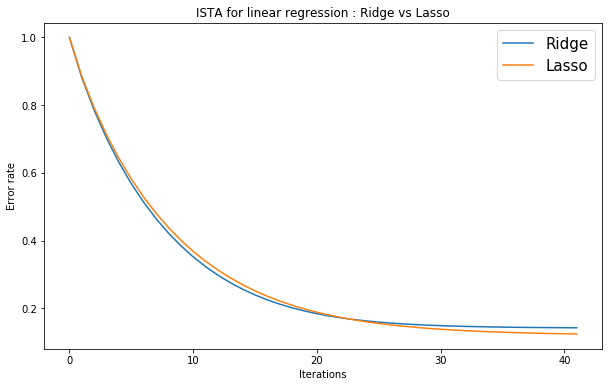

In [27]:
A,b=simu_linreg(coefs)
s = 0.01
plt.figure(figsize=(10,6))

x_ista,obj,err_ridge=ista(x0,loss_linreg,grad_linreg,ridge,prox_ridge,step=lip_linreg(A),s=s,n_iter=40 , 
                      verbose=False)
x_ista,obj,err_lasso=ista(x0,loss_linreg,grad_linreg,lasso,prox_lasso,step=lip_linreg(A),s=s,n_iter=40 , 
                      verbose=False)
plt.plot(err_ridge,label="Ridge")
plt.plot(err_lasso,label="Lasso")
plt.legend(prop={'size':15})
plt.xlabel("Iterations")
plt.ylabel("Error rate")
plt.title("ISTA for linear regression : Ridge vs Lasso")
    
plt.show()

### Lasso/Ridge for linear regression with FISTA :

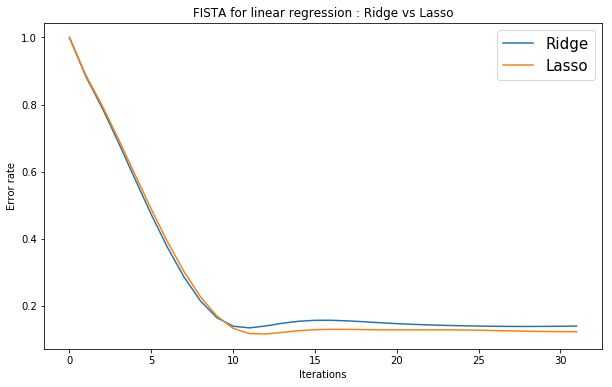

In [28]:
A,b=simu_linreg(coefs)
s = 0.01
plt.figure(figsize=(10,6))

x_fista,obj,err_ridge=fista(x0,loss_linreg,grad_linreg,ridge,prox_ridge,step=lip_linreg(A),s=s,n_iter=30 , 
                      verbose=False)
x_fista,obj,err_lasso=fista(x0,loss_linreg,grad_linreg,lasso,prox_lasso,step=lip_linreg(A),s=s,n_iter=30 , 
                      verbose=False)
plt.plot(err_ridge,label="Ridge")
plt.plot(err_lasso,label="Lasso")
plt.legend(prop={'size':15})
plt.xlabel("Iterations")
plt.ylabel("Error rate")
plt.title("FISTA for linear regression : Ridge vs Lasso")
    
plt.show()

### Lasso/Ridge for logistic regression with ISTA :

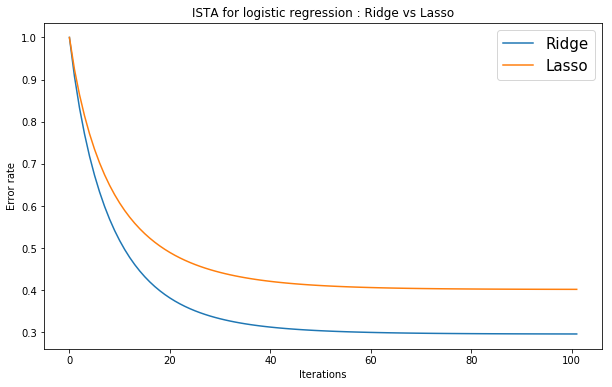

In [29]:
A,b=simu_logreg(coefs)
s = 0.01
plt.figure(figsize=(10,6))

x_ista,obj,err_ridge=ista(x0,loss_logreg,grad_logreg,ridge,prox_ridge,step=lip_logreg(A),s=s,n_iter=100 , 
                      verbose=False)
x_ista,obj,err_lasso=ista(x0,loss_logreg,grad_logreg,lasso,prox_lasso,step=lip_logreg(A),s=s,n_iter=100 , 
                      verbose=False)
plt.plot(err_ridge,label="Ridge")
plt.plot(err_lasso,label="Lasso")
plt.legend(prop={'size':15})
plt.xlabel("Iterations")
plt.ylabel("Error rate")
plt.title("ISTA for logistic regression : Ridge vs Lasso")
    
plt.show()

### Lasso/Ridge for logistic regression with FISTA :

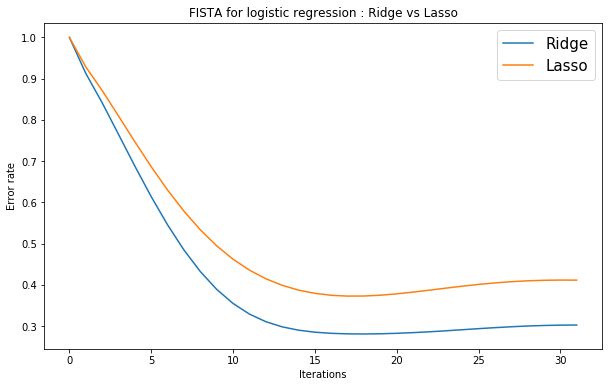

In [30]:
A,b=simu_logreg(coefs)
s = 0.01
plt.figure(figsize=(10,6))

x_fista,obj,err_ridge=fista(x0,loss_logreg,grad_logreg,ridge,prox_ridge,step=lip_logreg(A),s=s,n_iter=30 , 
                      verbose=False)
x_fista,obj,err_lasso=fista(x0,loss_logreg,grad_logreg,lasso,prox_lasso,step=lip_logreg(A),s=s,n_iter=30 , 
                      verbose=False)
plt.plot(err_ridge,label="Ridge")
plt.plot(err_lasso,label="Lasso")
plt.legend(prop={'size':15})
plt.xlabel("Iterations")
plt.ylabel("Error rate")
plt.title("FISTA for logistic regression : Ridge vs Lasso")
    
plt.show()

<div class="alert alert-info">
    <b>Answer</b>:
    <p>
    $\bullet$ We have almost the same convergence speed  for lasso and rigde , with the same algorithm and the same loss function.
    </p>
    <p>
    $\bullet$ But we notice that the convergence error rate of the Lasso is always higher than the Ridge error rate and it gets higher with higher penalty parameter. This could be explained by the fact that a lot of coefficients are shrinked to zero when we used the Lasso proximal operator ( as we saw in part 1 ).
    </p>
    <p>
    </p>
     
</div>